In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import pickle

from sklearn.preprocessing import StandardScaler

In [ ]:
data = pd.read_csv('Stocks.csv')
data

,AAPL,MSI,SBUX
0,67.8542,60.30,28.185
1,68.5614,60.90,28.070
2,66.8428,60.83,28.130
3,66.7156,60.81,27.915
4,66.6556,61.12,27.775
...,...,...,...
1254,167.7800,99.12,56.000
1255,160.5000,103.87,55.770
1256,156.4900,101.06,54.690
1257,163.0300,102.76,55.610


<AxesSubplot:>

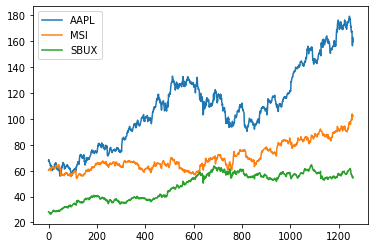

In [ ]:
data.plot()

In [ ]:
class MultiStockEnv:
    """
    A 3-stock trading environment.
    State: vector of size 7 (n_stock * 2 + 1)
        - # shares of stock 1 owned
        - # shares of stock 2 owned
        - # shares of stock 3 owned
        - price of stock 1 (using daily close price)
        - price of stock 2
        - price of stock 3
        - cash owned (can be used to purchase more stocks)
    Action: categorical variable with 27 (3^3) possibilities
        - for each stock, you can:
        - 0 = sell
        - 1 = hold
        - 2 = buy
    """
    def __init__(self, data, initial_investment=20000):
        # data
        self.stock_price_history = data
        self.n_step, self.n_stock = self.stock_price_history.shape

        # instance attributes
        self.initial_investment = initial_investment
        self.cur_step = None
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None

        self.action_space = np.arange(3**self.n_stock)

        # action permutations
        # returns a nested list with elements like:
        # [0,0,0]
        # [0,0,1]
        # [0,0,2]
        # [0,1,0]
        # [0,1,1]
        # etc.
        # 0 = sell
        # 1 = hold
        # 2 = buy
        self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

        # calculate size of state
        self.state_dim = self.n_stock * 2 + 1

        self.reset()


    def reset(self):
        self.cur_step = 0
        self.stock_owned = np.zeros(self.n_stock)
        self.stock_price = self.stock_price_history[self.cur_step]
        self.cash_in_hand = self.initial_investment
        return self._get_obs()


    def step(self, action):
        assert action in self.action_space

        # get current value before performing the action
        prev_val = self._get_val()

        # update price, i.e. go to the next day
        self.cur_step += 1
        self.stock_price = self.stock_price_history[self.cur_step]

        # perform the trade
        self._trade(action)

        # get the new value after taking the action
        cur_val = self._get_val()

        # reward is the increase in porfolio value
        reward = cur_val - prev_val

        # done if we have run out of data
        done = self.cur_step == self.n_step - 1

        # store the current value of the portfolio here
        info = {'cur_val': cur_val}

        # conform to the Gym API
        return self._get_obs(), reward, done, info


    def _get_obs(self):
        obs = np.empty(self.state_dim)
        obs[:self.n_stock] = self.stock_owned
        obs[self.n_stock:2*self.n_stock] = self.stock_price
        obs[-1] = self.cash_in_hand
        return obs
    
    def _get_val(self):
        return self.stock_owned.dot(self.stock_price) + self.cash_in_hand

    def _trade(self, action):
        # index the action we want to perform
        # 0 = sell
        # 1 = hold
        # 2 = buy
        # e.g. [2,1,0] means:
        # buy first stock
        # hold second stock
        # sell third stock
        action_vec = self.action_list[action]

        # determine which stocks to buy or sell
        sell_index = [] # stores index of stocks we want to sell
        buy_index = [] # stores index of stocks we want to buy
        for i, a in enumerate(action_vec):
            if a == 0:
                sell_index.append(i)
            elif a == 2:
                buy_index.append(i)

        # sell any stocks we want to sell
        # then buy any stocks we want to buy
        if sell_index:
            # NOTE: to simplify the problem, when we sell, we will sell ALL shares of that stock
            for i in sell_index:
                self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
                self.stock_owned[i] = 0
        if buy_index:
            # NOTE: when buying, we will loop through each stock we want to buy,
            #       and buy one share at a time until we run out of cash
            can_buy = True
            while can_buy:
                for i in buy_index:
                    if self.cash_in_hand > self.stock_price[i]:
                        self.stock_owned[i] += 1 # buy one share
                        self.cash_in_hand -= self.stock_price[i]
                    else:
                        can_buy = False

In [ ]:
n_timesteps, n_stocks = data.shape

In [ ]:
n_train = n_timesteps // 2
n_train

629

In [ ]:
train_data = data[:n_train].values
test_data = data[n_train:].values

In [ ]:
env = MultiStockEnv(train_data,initial_investment=20000)

In [ ]:
env.reset()

array([    0.    ,     0.    ,     0.    ,    67.8542,    60.3   ,
          28.185 , 20000.    ])

In [ ]:
env.action_list

[[0, 0, 0],
 [0, 0, 1],
 [0, 0, 2],
 [0, 1, 0],
 [0, 1, 1],
 [0, 1, 2],
 [0, 2, 0],
 [0, 2, 1],
 [0, 2, 2],
 [1, 0, 0],
 [1, 0, 1],
 [1, 0, 2],
 [1, 1, 0],
 [1, 1, 1],
 [1, 1, 2],
 [1, 2, 0],
 [1, 2, 1],
 [1, 2, 2],
 [2, 0, 0],
 [2, 0, 1],
 [2, 0, 2],
 [2, 1, 0],
 [2, 1, 1],
 [2, 1, 2],
 [2, 2, 0],
 [2, 2, 1],
 [2, 2, 2]]

In [ ]:
env.step(26)

(array([127.    , 127.    , 126.    ,  68.5614,  60.9   ,  28.07  ,
         21.5822]),
 3.2741809263825417e-11,
 False,
 {'cur_val': 20000.000000000033})

In [ ]:
def predict(X,W,b):
    # make sure X is N x D
    assert(len(X.shape) == 2)
    return X.dot(W) + b

In [ ]:
def sgd(X,Y,W,b,vW,vb,learning_rate=0.01, momentum=0.9):
    assert(len(X.shape) == 2)
    # the loss values are 2-D
    # normally we would divide by N only
    # but now we divide by N x K
    num_values = np.prod(Y.shape)
    # do one step of gradient descent
    # we multiply by 2 to get the exact gradient
    # (not adjusting the learning rate)
    # i.e. d/dx (x^2) --> 2x
    Yhat = predict(X,W,b)
    gW = 2 * X.T.dot(Yhat - Y) / num_values
    gb = 2 * (Yhat - Y).sum(axis=0) / num_values

    # update momentum terms
    vW = momentum * vW - learning_rate * gW
    vb = momentum * vb - learning_rate * gb

    # update params
    W += vW
    b += vb
    return W,b,vW,vb

In [ ]:
def greedy_policy(state,W,b,epsilon):
    if np.random.rand() <= epsilon:
        return np.random.choice(action_size)
    else:
        act_values = predict(state,W,b)
        return np.argmax(act_values[0])  # returns action

In [ ]:
def get_scaler(env):
    # return scikit-learn scaler object to scale the states after fitting the scaler with some random actions
    states = []
    #play game 100 times with random actions to collect some states
    for i in range(100):
        for j in range(env.n_step):
            action = np.random.choice(env.action_space)
            state, reward, done, info = env.step(action)
            states.append(state)
            if done:
                env.reset()
                break
    scaler = StandardScaler()
    scaler.fit(states)
    return scaler

In [ ]:
gamma = 0.95  # discount rate
epsilon = 1.0  # exploration rate
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 2000
initial_investment = 20000

n_timesteps, n_stocks = data.shape
n_train = n_timesteps // 2
train_data = data[:n_train].values
test_data = data[n_train:].values

np.random.seed(1)
env = MultiStockEnv(train_data,initial_investment=20000)
#Train the scaler, the scaler only uses the training set
state_size = env.state_dim
action_size = len(env.action_space)

#Initialize weights
W = np.random.randn(state_size, action_size) / np.sqrt(state_size)
b = np.zeros(action_size)
scaler=get_scaler(env)

#Initialize momentum terms
vW = 0
vb = 0

# store the final value of the portfolio (end of episode)
portfolio_value = []

for i in range(num_episodes):
    done=False
    state = env.reset()
    state = scaler.transform([state])
    while not done:
        action = greedy_policy(state,W,b,epsilon)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        if done:
            target = reward
        else:
            target = reward + gamma * np.amax(predict(next_state,W,b), axis=1)
        #Make prediction for all actions first
        target_full = predict(state,W,b)
        #Update target values for only the selected action 
        target_full[0, action] = target
        #Update weights
        W,b,vW,vb=sgd(X=state, Y=target_full,W=W,b=b,vW=vW,vb=vb)
        
        state=next_state
        
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
        
    val=info['cur_val']
    print(f"episode: {i + 1}/{num_episodes}, episode end value: {val:.2f}")
    portfolio_value.append(val)
pickle.dump(scaler, open('scaler.pkl','wb'))
np.savez("TraderWeights.npz", W=W, b=b)

episode: 1/2000, episode end value: 25076.33
episode: 2/2000, episode end value: 36735.00
episode: 3/2000, episode end value: 40398.62
episode: 4/2000, episode end value: 40331.56
episode: 5/2000, episode end value: 31233.82
episode: 6/2000, episode end value: 42363.55
episode: 7/2000, episode end value: 39928.64
episode: 8/2000, episode end value: 40561.07
episode: 9/2000, episode end value: 40221.22
episode: 10/2000, episode end value: 32520.09
episode: 11/2000, episode end value: 33978.18
episode: 12/2000, episode end value: 41345.52
episode: 13/2000, episode end value: 42897.90
episode: 14/2000, episode end value: 45076.61
episode: 15/2000, episode end value: 40929.00
episode: 16/2000, episode end value: 33324.44
episode: 17/2000, episode end value: 33702.96
episode: 18/2000, episode end value: 37539.11
episode: 19/2000, episode end value: 40346.94
episode: 20/2000, episode end value: 40841.95
episode: 21/2000, episode end value: 43448.17
episode: 22/2000, episode end value: 42113.

episode: 179/2000, episode end value: 43686.29
episode: 180/2000, episode end value: 47905.75
episode: 181/2000, episode end value: 40866.62
episode: 182/2000, episode end value: 34668.01
episode: 183/2000, episode end value: 40963.17
episode: 184/2000, episode end value: 42747.66
episode: 185/2000, episode end value: 40406.09
episode: 186/2000, episode end value: 42744.00
episode: 187/2000, episode end value: 41472.20
episode: 188/2000, episode end value: 39214.82
episode: 189/2000, episode end value: 45141.69
episode: 190/2000, episode end value: 44027.81
episode: 191/2000, episode end value: 44909.07
episode: 192/2000, episode end value: 40168.53
episode: 193/2000, episode end value: 41554.31
episode: 194/2000, episode end value: 40564.11
episode: 195/2000, episode end value: 44788.06
episode: 196/2000, episode end value: 42908.13
episode: 197/2000, episode end value: 43563.36
episode: 198/2000, episode end value: 40338.09
episode: 199/2000, episode end value: 47873.73
episode: 200/

episode: 355/2000, episode end value: 48057.88
episode: 356/2000, episode end value: 44029.30
episode: 357/2000, episode end value: 41931.06
episode: 358/2000, episode end value: 45022.04
episode: 359/2000, episode end value: 42921.84
episode: 360/2000, episode end value: 52474.06
episode: 361/2000, episode end value: 42734.72
episode: 362/2000, episode end value: 39943.40
episode: 363/2000, episode end value: 44755.92
episode: 364/2000, episode end value: 39617.85
episode: 365/2000, episode end value: 42619.46
episode: 366/2000, episode end value: 45937.82
episode: 367/2000, episode end value: 45665.46
episode: 368/2000, episode end value: 38961.71
episode: 369/2000, episode end value: 44673.49
episode: 370/2000, episode end value: 46564.70
episode: 371/2000, episode end value: 44521.70
episode: 372/2000, episode end value: 45792.19
episode: 373/2000, episode end value: 43340.24
episode: 374/2000, episode end value: 44476.92
episode: 375/2000, episode end value: 47452.53
episode: 376/

episode: 530/2000, episode end value: 44005.57
episode: 531/2000, episode end value: 51631.02
episode: 532/2000, episode end value: 52140.80
episode: 533/2000, episode end value: 47207.99
episode: 534/2000, episode end value: 54179.35
episode: 535/2000, episode end value: 51807.80
episode: 536/2000, episode end value: 46538.08
episode: 537/2000, episode end value: 46349.84
episode: 538/2000, episode end value: 48548.52
episode: 539/2000, episode end value: 53435.10
episode: 540/2000, episode end value: 53476.62
episode: 541/2000, episode end value: 45047.29
episode: 542/2000, episode end value: 45480.88
episode: 543/2000, episode end value: 50652.97
episode: 544/2000, episode end value: 58911.89
episode: 545/2000, episode end value: 55305.66
episode: 546/2000, episode end value: 51202.52
episode: 547/2000, episode end value: 56218.92
episode: 548/2000, episode end value: 51187.06
episode: 549/2000, episode end value: 54258.66
episode: 550/2000, episode end value: 51790.56
episode: 551/

episode: 705/2000, episode end value: 49738.03
episode: 706/2000, episode end value: 59346.63
episode: 707/2000, episode end value: 52756.67
episode: 708/2000, episode end value: 55416.15
episode: 709/2000, episode end value: 55542.74
episode: 710/2000, episode end value: 53254.73
episode: 711/2000, episode end value: 45708.77
episode: 712/2000, episode end value: 57748.59
episode: 713/2000, episode end value: 53544.46
episode: 714/2000, episode end value: 57899.84
episode: 715/2000, episode end value: 42805.82
episode: 716/2000, episode end value: 49829.22
episode: 717/2000, episode end value: 49014.08
episode: 718/2000, episode end value: 52203.33
episode: 719/2000, episode end value: 42114.90
episode: 720/2000, episode end value: 39205.12
episode: 721/2000, episode end value: 43342.99
episode: 722/2000, episode end value: 60797.53
episode: 723/2000, episode end value: 45707.66
episode: 724/2000, episode end value: 46641.08
episode: 725/2000, episode end value: 38118.12
episode: 726/

episode: 880/2000, episode end value: 52700.03
episode: 881/2000, episode end value: 48256.02
episode: 882/2000, episode end value: 47736.77
episode: 883/2000, episode end value: 39686.12
episode: 884/2000, episode end value: 48694.85
episode: 885/2000, episode end value: 52722.19
episode: 886/2000, episode end value: 61548.14
episode: 887/2000, episode end value: 43383.58
episode: 888/2000, episode end value: 47244.07
episode: 889/2000, episode end value: 59189.24
episode: 890/2000, episode end value: 55484.56
episode: 891/2000, episode end value: 61030.33
episode: 892/2000, episode end value: 51759.19
episode: 893/2000, episode end value: 48771.45
episode: 894/2000, episode end value: 58926.86
episode: 895/2000, episode end value: 54271.98
episode: 896/2000, episode end value: 54824.04
episode: 897/2000, episode end value: 48787.56
episode: 898/2000, episode end value: 54046.26
episode: 899/2000, episode end value: 47028.70
episode: 900/2000, episode end value: 63974.67
episode: 901/

episode: 1054/2000, episode end value: 55933.02
episode: 1055/2000, episode end value: 44328.26
episode: 1056/2000, episode end value: 50339.42
episode: 1057/2000, episode end value: 46779.32
episode: 1058/2000, episode end value: 40216.10
episode: 1059/2000, episode end value: 51847.20
episode: 1060/2000, episode end value: 45363.00
episode: 1061/2000, episode end value: 35864.31
episode: 1062/2000, episode end value: 61501.08
episode: 1063/2000, episode end value: 56699.47
episode: 1064/2000, episode end value: 54524.13
episode: 1065/2000, episode end value: 60415.85
episode: 1066/2000, episode end value: 52897.85
episode: 1067/2000, episode end value: 47319.49
episode: 1068/2000, episode end value: 49951.34
episode: 1069/2000, episode end value: 53126.96
episode: 1070/2000, episode end value: 62310.19
episode: 1071/2000, episode end value: 57006.64
episode: 1072/2000, episode end value: 58583.07
episode: 1073/2000, episode end value: 52085.47
episode: 1074/2000, episode end value: 5

episode: 1225/2000, episode end value: 55463.53
episode: 1226/2000, episode end value: 49825.62
episode: 1227/2000, episode end value: 51098.68
episode: 1228/2000, episode end value: 52620.80
episode: 1229/2000, episode end value: 53641.11
episode: 1230/2000, episode end value: 53143.64
episode: 1231/2000, episode end value: 50499.06
episode: 1232/2000, episode end value: 55748.11
episode: 1233/2000, episode end value: 52233.63
episode: 1234/2000, episode end value: 48750.54
episode: 1235/2000, episode end value: 50266.64
episode: 1236/2000, episode end value: 51204.03
episode: 1237/2000, episode end value: 52690.32
episode: 1238/2000, episode end value: 55001.55
episode: 1239/2000, episode end value: 47569.64
episode: 1240/2000, episode end value: 45199.72
episode: 1241/2000, episode end value: 52318.59
episode: 1242/2000, episode end value: 53440.57
episode: 1243/2000, episode end value: 50230.46
episode: 1244/2000, episode end value: 48260.74
episode: 1245/2000, episode end value: 5

episode: 1397/2000, episode end value: 55184.59
episode: 1398/2000, episode end value: 47569.15
episode: 1399/2000, episode end value: 46889.41
episode: 1400/2000, episode end value: 56129.39
episode: 1401/2000, episode end value: 50884.56
episode: 1402/2000, episode end value: 56329.90
episode: 1403/2000, episode end value: 50731.43
episode: 1404/2000, episode end value: 51146.95
episode: 1405/2000, episode end value: 51313.89
episode: 1406/2000, episode end value: 48504.56
episode: 1407/2000, episode end value: 47293.81
episode: 1408/2000, episode end value: 49323.03
episode: 1409/2000, episode end value: 50937.48
episode: 1410/2000, episode end value: 56516.08
episode: 1411/2000, episode end value: 40715.53
episode: 1412/2000, episode end value: 46064.60
episode: 1413/2000, episode end value: 44451.04
episode: 1414/2000, episode end value: 47397.99
episode: 1415/2000, episode end value: 44298.42
episode: 1416/2000, episode end value: 49837.26
episode: 1417/2000, episode end value: 4

episode: 1568/2000, episode end value: 60988.00
episode: 1569/2000, episode end value: 49972.90
episode: 1570/2000, episode end value: 55745.06
episode: 1571/2000, episode end value: 54164.15
episode: 1572/2000, episode end value: 54412.44
episode: 1573/2000, episode end value: 44981.73
episode: 1574/2000, episode end value: 54343.01
episode: 1575/2000, episode end value: 54831.50
episode: 1576/2000, episode end value: 60667.30
episode: 1577/2000, episode end value: 61605.45
episode: 1578/2000, episode end value: 59742.10
episode: 1579/2000, episode end value: 57309.40
episode: 1580/2000, episode end value: 52550.14
episode: 1581/2000, episode end value: 59985.55
episode: 1582/2000, episode end value: 54090.43
episode: 1583/2000, episode end value: 54993.87
episode: 1584/2000, episode end value: 52059.04
episode: 1585/2000, episode end value: 55617.24
episode: 1586/2000, episode end value: 58738.13
episode: 1587/2000, episode end value: 52606.06
episode: 1588/2000, episode end value: 5

episode: 1739/2000, episode end value: 46106.08
episode: 1740/2000, episode end value: 47381.47
episode: 1741/2000, episode end value: 56732.65
episode: 1742/2000, episode end value: 47616.92
episode: 1743/2000, episode end value: 45834.63
episode: 1744/2000, episode end value: 56008.72
episode: 1745/2000, episode end value: 52906.44
episode: 1746/2000, episode end value: 50389.50
episode: 1747/2000, episode end value: 51117.30
episode: 1748/2000, episode end value: 52475.98
episode: 1749/2000, episode end value: 58168.06
episode: 1750/2000, episode end value: 50047.64
episode: 1751/2000, episode end value: 51810.26
episode: 1752/2000, episode end value: 60255.74
episode: 1753/2000, episode end value: 52306.86
episode: 1754/2000, episode end value: 51246.46
episode: 1755/2000, episode end value: 50995.16
episode: 1756/2000, episode end value: 55256.42
episode: 1757/2000, episode end value: 48318.72
episode: 1758/2000, episode end value: 52909.63
episode: 1759/2000, episode end value: 4

episode: 1910/2000, episode end value: 46335.39
episode: 1911/2000, episode end value: 52546.47
episode: 1912/2000, episode end value: 53769.17
episode: 1913/2000, episode end value: 64675.47
episode: 1914/2000, episode end value: 52515.15
episode: 1915/2000, episode end value: 47729.82
episode: 1916/2000, episode end value: 61015.70
episode: 1917/2000, episode end value: 56925.96
episode: 1918/2000, episode end value: 60907.22
episode: 1919/2000, episode end value: 58515.92
episode: 1920/2000, episode end value: 64673.50
episode: 1921/2000, episode end value: 67019.34
episode: 1922/2000, episode end value: 49547.38
episode: 1923/2000, episode end value: 50145.38
episode: 1924/2000, episode end value: 47031.71
episode: 1925/2000, episode end value: 48563.00
episode: 1926/2000, episode end value: 49092.71
episode: 1927/2000, episode end value: 53171.95
episode: 1928/2000, episode end value: 42029.64
episode: 1929/2000, episode end value: 48889.16
episode: 1930/2000, episode end value: 5

In [ ]:
scaler = pickle.load(open('scaler.pkl', 'rb'))
npz = np.load("TraderWeights.npz")
W = npz['W']
b = npz['b']

In [ ]:
W

array([[   32.83148756,    42.26844643,   112.36531712,   -46.942872  ,
          -13.15837934,   310.26803516,   236.36452484,    88.06862184,
          -51.04960342,   -12.62067289,     5.44769994,  -138.32568599,
          -35.32292157,   -16.05271208,    59.10567529,  -152.47233468,
            2.94498377,   -42.48940492,     2.89605705,   -75.16950951,
          -64.88545615,    60.40708616,  -141.57977464,    15.97932904,
          -99.55195364,    27.90051055,   239.1075172 ],
       [  104.22134201,   109.77812981,   161.13855424,    91.0498618 ,
           69.25101507,   215.11603475,   270.75433714,   145.23850725,
          123.52467422,    91.25798624,   147.2930214 ,    -2.77251905,
           91.24115536,   139.98235631,   117.7955985 ,   -28.24383632,
          117.46098082,   142.42056536,    90.4846414 ,   150.33020862,
          130.50655459,   186.92259587,    34.84501118,   128.76064799,
           73.29286821,   120.44052443,   538.1027146 ],
       [   92.07519355

In [ ]:
np.random.seed(1)
#Test the performance of the agent with the test data
epsilon = 0.01
env = MultiStockEnv(test_data, initial_investment)
testportfoliovalues=[]
for i in range(num_episodes):
    state = env.reset()
    state = scaler.transform([state])
    done=False
    while not done:
        action = greedy_policy(state,W,b,epsilon=epsilon)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
    value=info['cur_val']
    print(f"episode: {i + 1}/{num_episodes}, episode end value: {value:.2f}")
    testportfoliovalues.append(value) # append episode end portfolio value

episode: 1/2000, episode end value: 32227.39
episode: 2/2000, episode end value: 32373.20
episode: 3/2000, episode end value: 24727.41
episode: 4/2000, episode end value: 34656.15
episode: 5/2000, episode end value: 27286.21
episode: 6/2000, episode end value: 33765.02
episode: 7/2000, episode end value: 36077.70
episode: 8/2000, episode end value: 30373.30
episode: 9/2000, episode end value: 32373.20
episode: 10/2000, episode end value: 29815.24
episode: 11/2000, episode end value: 36976.35
episode: 12/2000, episode end value: 31396.75
episode: 13/2000, episode end value: 31547.79
episode: 14/2000, episode end value: 30077.67
episode: 15/2000, episode end value: 30822.07
episode: 16/2000, episode end value: 32226.96
episode: 17/2000, episode end value: 28105.81
episode: 18/2000, episode end value: 32443.69
episode: 19/2000, episode end value: 29147.23
episode: 20/2000, episode end value: 26731.01
episode: 21/2000, episode end value: 29423.32
episode: 22/2000, episode end value: 31628.

episode: 179/2000, episode end value: 27863.58
episode: 180/2000, episode end value: 32278.24
episode: 181/2000, episode end value: 25526.44
episode: 182/2000, episode end value: 31877.24
episode: 183/2000, episode end value: 32535.07
episode: 184/2000, episode end value: 30477.96
episode: 185/2000, episode end value: 27867.33
episode: 186/2000, episode end value: 32657.31
episode: 187/2000, episode end value: 25274.69
episode: 188/2000, episode end value: 32373.20
episode: 189/2000, episode end value: 32373.20
episode: 190/2000, episode end value: 29078.68
episode: 191/2000, episode end value: 24357.75
episode: 192/2000, episode end value: 24432.40
episode: 193/2000, episode end value: 32373.20
episode: 194/2000, episode end value: 25852.33
episode: 195/2000, episode end value: 29160.75
episode: 196/2000, episode end value: 32791.06
episode: 197/2000, episode end value: 32248.60
episode: 198/2000, episode end value: 32373.20
episode: 199/2000, episode end value: 32959.83
episode: 200/

episode: 356/2000, episode end value: 30629.66
episode: 357/2000, episode end value: 24953.02
episode: 358/2000, episode end value: 28204.61
episode: 359/2000, episode end value: 21318.33
episode: 360/2000, episode end value: 25406.26
episode: 361/2000, episode end value: 32582.49
episode: 362/2000, episode end value: 28349.63
episode: 363/2000, episode end value: 31408.35
episode: 364/2000, episode end value: 24468.66
episode: 365/2000, episode end value: 32364.74
episode: 366/2000, episode end value: 28994.46
episode: 367/2000, episode end value: 32373.20
episode: 368/2000, episode end value: 27920.50
episode: 369/2000, episode end value: 24889.41
episode: 370/2000, episode end value: 30023.16
episode: 371/2000, episode end value: 24452.93
episode: 372/2000, episode end value: 30228.22
episode: 373/2000, episode end value: 27285.15
episode: 374/2000, episode end value: 27065.31
episode: 375/2000, episode end value: 30357.95
episode: 376/2000, episode end value: 30050.64
episode: 377/

episode: 533/2000, episode end value: 32373.20
episode: 534/2000, episode end value: 32354.30
episode: 535/2000, episode end value: 27494.03
episode: 536/2000, episode end value: 24593.29
episode: 537/2000, episode end value: 26049.85
episode: 538/2000, episode end value: 28075.58
episode: 539/2000, episode end value: 34011.58
episode: 540/2000, episode end value: 25163.47
episode: 541/2000, episode end value: 37359.07
episode: 542/2000, episode end value: 28525.94
episode: 543/2000, episode end value: 32373.20
episode: 544/2000, episode end value: 32138.89
episode: 545/2000, episode end value: 32488.46
episode: 546/2000, episode end value: 31133.64
episode: 547/2000, episode end value: 28440.35
episode: 548/2000, episode end value: 32373.20
episode: 549/2000, episode end value: 27040.31
episode: 550/2000, episode end value: 32373.20
episode: 551/2000, episode end value: 31627.72
episode: 552/2000, episode end value: 24675.10
episode: 553/2000, episode end value: 27834.66
episode: 554/

episode: 708/2000, episode end value: 25545.78
episode: 709/2000, episode end value: 28660.67
episode: 710/2000, episode end value: 29597.14
episode: 711/2000, episode end value: 32350.70
episode: 712/2000, episode end value: 27927.29
episode: 713/2000, episode end value: 28134.50
episode: 714/2000, episode end value: 32373.20
episode: 715/2000, episode end value: 27018.66
episode: 716/2000, episode end value: 28793.08
episode: 717/2000, episode end value: 32329.10
episode: 718/2000, episode end value: 31623.36
episode: 719/2000, episode end value: 27239.69
episode: 720/2000, episode end value: 26955.04
episode: 721/2000, episode end value: 29985.81
episode: 722/2000, episode end value: 27357.29
episode: 723/2000, episode end value: 27087.99
episode: 724/2000, episode end value: 24336.95
episode: 725/2000, episode end value: 32362.07
episode: 726/2000, episode end value: 32566.63
episode: 727/2000, episode end value: 32638.44
episode: 728/2000, episode end value: 27917.41
episode: 729/

episode: 884/2000, episode end value: 27016.70
episode: 885/2000, episode end value: 32249.93
episode: 886/2000, episode end value: 32575.56
episode: 887/2000, episode end value: 32373.20
episode: 888/2000, episode end value: 29639.35
episode: 889/2000, episode end value: 27173.27
episode: 890/2000, episode end value: 32572.17
episode: 891/2000, episode end value: 25902.83
episode: 892/2000, episode end value: 25178.48
episode: 893/2000, episode end value: 29401.49
episode: 894/2000, episode end value: 23070.59
episode: 895/2000, episode end value: 32440.15
episode: 896/2000, episode end value: 32373.20
episode: 897/2000, episode end value: 32653.61
episode: 898/2000, episode end value: 23093.36
episode: 899/2000, episode end value: 32274.70
episode: 900/2000, episode end value: 28659.64
episode: 901/2000, episode end value: 32171.07
episode: 902/2000, episode end value: 28390.24
episode: 903/2000, episode end value: 28630.54
episode: 904/2000, episode end value: 29031.32
episode: 905/

episode: 1058/2000, episode end value: 33011.08
episode: 1059/2000, episode end value: 28702.40
episode: 1060/2000, episode end value: 32373.20
episode: 1061/2000, episode end value: 29956.52
episode: 1062/2000, episode end value: 28997.37
episode: 1063/2000, episode end value: 26065.49
episode: 1064/2000, episode end value: 29108.92
episode: 1065/2000, episode end value: 21307.55
episode: 1066/2000, episode end value: 32363.50
episode: 1067/2000, episode end value: 32266.49
episode: 1068/2000, episode end value: 24188.68
episode: 1069/2000, episode end value: 31828.90
episode: 1070/2000, episode end value: 32373.20
episode: 1071/2000, episode end value: 33477.30
episode: 1072/2000, episode end value: 32373.20
episode: 1073/2000, episode end value: 26899.91
episode: 1074/2000, episode end value: 30314.96
episode: 1075/2000, episode end value: 32328.94
episode: 1076/2000, episode end value: 26472.89
episode: 1077/2000, episode end value: 32373.20
episode: 1078/2000, episode end value: 2

episode: 1230/2000, episode end value: 22579.62
episode: 1231/2000, episode end value: 32944.39
episode: 1232/2000, episode end value: 32469.45
episode: 1233/2000, episode end value: 27303.05
episode: 1234/2000, episode end value: 27381.90
episode: 1235/2000, episode end value: 23830.66
episode: 1236/2000, episode end value: 26331.39
episode: 1237/2000, episode end value: 30847.60
episode: 1238/2000, episode end value: 31074.28
episode: 1239/2000, episode end value: 27101.84
episode: 1240/2000, episode end value: 26034.61
episode: 1241/2000, episode end value: 27848.52
episode: 1242/2000, episode end value: 27819.87
episode: 1243/2000, episode end value: 32373.20
episode: 1244/2000, episode end value: 20903.62
episode: 1245/2000, episode end value: 29992.22
episode: 1246/2000, episode end value: 32373.20
episode: 1247/2000, episode end value: 28103.20
episode: 1248/2000, episode end value: 29631.89
episode: 1249/2000, episode end value: 28153.82
episode: 1250/2000, episode end value: 3

episode: 1401/2000, episode end value: 28828.39
episode: 1402/2000, episode end value: 27026.13
episode: 1403/2000, episode end value: 33918.65
episode: 1404/2000, episode end value: 30022.88
episode: 1405/2000, episode end value: 32405.06
episode: 1406/2000, episode end value: 24153.70
episode: 1407/2000, episode end value: 31973.65
episode: 1408/2000, episode end value: 22849.20
episode: 1409/2000, episode end value: 27993.12
episode: 1410/2000, episode end value: 33271.39
episode: 1411/2000, episode end value: 30235.08
episode: 1412/2000, episode end value: 32227.85
episode: 1413/2000, episode end value: 29210.28
episode: 1414/2000, episode end value: 24959.62
episode: 1415/2000, episode end value: 26232.32
episode: 1416/2000, episode end value: 31114.87
episode: 1417/2000, episode end value: 31135.83
episode: 1418/2000, episode end value: 32373.20
episode: 1419/2000, episode end value: 32373.20
episode: 1420/2000, episode end value: 25592.02
episode: 1421/2000, episode end value: 2

episode: 1574/2000, episode end value: 25137.29
episode: 1575/2000, episode end value: 33167.76
episode: 1576/2000, episode end value: 30074.65
episode: 1577/2000, episode end value: 31925.62
episode: 1578/2000, episode end value: 30924.07
episode: 1579/2000, episode end value: 24414.64
episode: 1580/2000, episode end value: 27671.59
episode: 1581/2000, episode end value: 23200.28
episode: 1582/2000, episode end value: 28571.30
episode: 1583/2000, episode end value: 29654.39
episode: 1584/2000, episode end value: 28732.13
episode: 1585/2000, episode end value: 29330.70
episode: 1586/2000, episode end value: 32373.20
episode: 1587/2000, episode end value: 24594.38
episode: 1588/2000, episode end value: 32373.20
episode: 1589/2000, episode end value: 31410.66
episode: 1590/2000, episode end value: 33101.75
episode: 1591/2000, episode end value: 32373.20
episode: 1592/2000, episode end value: 32373.20
episode: 1593/2000, episode end value: 32373.20
episode: 1594/2000, episode end value: 2

episode: 1745/2000, episode end value: 24095.83
episode: 1746/2000, episode end value: 29578.87
episode: 1747/2000, episode end value: 23052.02
episode: 1748/2000, episode end value: 25602.23
episode: 1749/2000, episode end value: 32643.05
episode: 1750/2000, episode end value: 28495.75
episode: 1751/2000, episode end value: 29870.64
episode: 1752/2000, episode end value: 32058.65
episode: 1753/2000, episode end value: 34807.13
episode: 1754/2000, episode end value: 27480.56
episode: 1755/2000, episode end value: 28985.19
episode: 1756/2000, episode end value: 32451.75
episode: 1757/2000, episode end value: 32435.96
episode: 1758/2000, episode end value: 29587.15
episode: 1759/2000, episode end value: 28050.72
episode: 1760/2000, episode end value: 30159.72
episode: 1761/2000, episode end value: 29453.59
episode: 1762/2000, episode end value: 27147.80
episode: 1763/2000, episode end value: 29582.38
episode: 1764/2000, episode end value: 28966.34
episode: 1765/2000, episode end value: 3

episode: 1917/2000, episode end value: 29507.43
episode: 1918/2000, episode end value: 29085.39
episode: 1919/2000, episode end value: 27241.55
episode: 1920/2000, episode end value: 29991.14
episode: 1921/2000, episode end value: 30843.60
episode: 1922/2000, episode end value: 32373.20
episode: 1923/2000, episode end value: 34863.49
episode: 1924/2000, episode end value: 32283.14
episode: 1925/2000, episode end value: 31716.55
episode: 1926/2000, episode end value: 31524.06
episode: 1927/2000, episode end value: 29045.56
episode: 1928/2000, episode end value: 26984.98
episode: 1929/2000, episode end value: 28582.73
episode: 1930/2000, episode end value: 32974.88
episode: 1931/2000, episode end value: 32253.22
episode: 1932/2000, episode end value: 25142.19
episode: 1933/2000, episode end value: 26920.50
episode: 1934/2000, episode end value: 30623.45
episode: 1935/2000, episode end value: 28893.98
episode: 1936/2000, episode end value: 28210.54
episode: 1937/2000, episode end value: 3

In [ ]:
np.random.seed(1)
#How does a random policy do?
epsilon = 1
env = MultiStockEnv(test_data, initial_investment)
randomportfoliovalues=[]
for i in range(num_episodes):
    state = env.reset()
    state = scaler.transform([state])
    done=False
    while not done:
        action = greedy_policy(state,W,b,epsilon=epsilon)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
    value=info['cur_val']
    print(f"episode: {i + 1}/{num_episodes}, episode end value: {value:.2f}")
    randomportfoliovalues.append(value) # append episode end portfolio value

episode: 1/2000, episode end value: 21172.47
episode: 2/2000, episode end value: 30347.43
episode: 3/2000, episode end value: 22427.10
episode: 4/2000, episode end value: 38796.15
episode: 5/2000, episode end value: 38920.86
episode: 6/2000, episode end value: 31671.02
episode: 7/2000, episode end value: 32637.78
episode: 8/2000, episode end value: 23404.49
episode: 9/2000, episode end value: 20608.17
episode: 10/2000, episode end value: 46674.31
episode: 11/2000, episode end value: 21318.84
episode: 12/2000, episode end value: 30278.56
episode: 13/2000, episode end value: 14336.00
episode: 14/2000, episode end value: 29408.74
episode: 15/2000, episode end value: 25824.91
episode: 16/2000, episode end value: 30745.74
episode: 17/2000, episode end value: 27527.49
episode: 18/2000, episode end value: 28777.44
episode: 19/2000, episode end value: 23216.20
episode: 20/2000, episode end value: 32913.26
episode: 21/2000, episode end value: 33793.09
episode: 22/2000, episode end value: 22321.

episode: 179/2000, episode end value: 18933.72
episode: 180/2000, episode end value: 15192.68
episode: 181/2000, episode end value: 29151.91
episode: 182/2000, episode end value: 20409.30
episode: 183/2000, episode end value: 33186.67
episode: 184/2000, episode end value: 23218.18
episode: 185/2000, episode end value: 30295.30
episode: 186/2000, episode end value: 21294.87
episode: 187/2000, episode end value: 14650.81
episode: 188/2000, episode end value: 29432.36
episode: 189/2000, episode end value: 24857.21
episode: 190/2000, episode end value: 39727.41
episode: 191/2000, episode end value: 25620.36
episode: 192/2000, episode end value: 22884.17
episode: 193/2000, episode end value: 17756.91
episode: 194/2000, episode end value: 21253.75
episode: 195/2000, episode end value: 23182.10
episode: 196/2000, episode end value: 31193.22
episode: 197/2000, episode end value: 21781.22
episode: 198/2000, episode end value: 27083.81
episode: 199/2000, episode end value: 16415.94
episode: 200/

episode: 354/2000, episode end value: 20531.33
episode: 355/2000, episode end value: 31577.20
episode: 356/2000, episode end value: 23393.69
episode: 357/2000, episode end value: 25588.68
episode: 358/2000, episode end value: 26152.51
episode: 359/2000, episode end value: 20823.34
episode: 360/2000, episode end value: 20659.97
episode: 361/2000, episode end value: 26586.76
episode: 362/2000, episode end value: 26112.69
episode: 363/2000, episode end value: 23383.10
episode: 364/2000, episode end value: 26863.97
episode: 365/2000, episode end value: 26541.25
episode: 366/2000, episode end value: 26415.80
episode: 367/2000, episode end value: 24936.80
episode: 368/2000, episode end value: 17860.77
episode: 369/2000, episode end value: 29537.65
episode: 370/2000, episode end value: 35306.85
episode: 371/2000, episode end value: 17543.81
episode: 372/2000, episode end value: 29423.30
episode: 373/2000, episode end value: 28819.34
episode: 374/2000, episode end value: 25725.95
episode: 375/

episode: 529/2000, episode end value: 27432.63
episode: 530/2000, episode end value: 23540.89
episode: 531/2000, episode end value: 23309.78
episode: 532/2000, episode end value: 24209.91
episode: 533/2000, episode end value: 24070.17
episode: 534/2000, episode end value: 21255.10
episode: 535/2000, episode end value: 24256.21
episode: 536/2000, episode end value: 29792.77
episode: 537/2000, episode end value: 41172.42
episode: 538/2000, episode end value: 28809.71
episode: 539/2000, episode end value: 23534.63
episode: 540/2000, episode end value: 24655.09
episode: 541/2000, episode end value: 20362.29
episode: 542/2000, episode end value: 24627.06
episode: 543/2000, episode end value: 26632.54
episode: 544/2000, episode end value: 22772.26
episode: 545/2000, episode end value: 22511.68
episode: 546/2000, episode end value: 37616.61
episode: 547/2000, episode end value: 26219.06
episode: 548/2000, episode end value: 22529.20
episode: 549/2000, episode end value: 37558.42
episode: 550/

episode: 705/2000, episode end value: 32286.90
episode: 706/2000, episode end value: 24743.90
episode: 707/2000, episode end value: 28929.77
episode: 708/2000, episode end value: 18296.61
episode: 709/2000, episode end value: 24108.58
episode: 710/2000, episode end value: 27559.51
episode: 711/2000, episode end value: 26931.57
episode: 712/2000, episode end value: 28450.64
episode: 713/2000, episode end value: 24404.80
episode: 714/2000, episode end value: 32017.31
episode: 715/2000, episode end value: 18661.83
episode: 716/2000, episode end value: 22164.52
episode: 717/2000, episode end value: 21668.99
episode: 718/2000, episode end value: 23942.25
episode: 719/2000, episode end value: 31822.85
episode: 720/2000, episode end value: 26032.63
episode: 721/2000, episode end value: 31458.61
episode: 722/2000, episode end value: 25074.05
episode: 723/2000, episode end value: 29438.70
episode: 724/2000, episode end value: 26598.91
episode: 725/2000, episode end value: 28361.70
episode: 726/

episode: 881/2000, episode end value: 27343.88
episode: 882/2000, episode end value: 21755.02
episode: 883/2000, episode end value: 19773.10
episode: 884/2000, episode end value: 31316.45
episode: 885/2000, episode end value: 20569.15
episode: 886/2000, episode end value: 20397.81
episode: 887/2000, episode end value: 27388.61
episode: 888/2000, episode end value: 22979.56
episode: 889/2000, episode end value: 18982.37
episode: 890/2000, episode end value: 25262.01
episode: 891/2000, episode end value: 17821.46
episode: 892/2000, episode end value: 16928.06
episode: 893/2000, episode end value: 28369.11
episode: 894/2000, episode end value: 29330.23
episode: 895/2000, episode end value: 28669.94
episode: 896/2000, episode end value: 21364.77
episode: 897/2000, episode end value: 29815.15
episode: 898/2000, episode end value: 20321.41
episode: 899/2000, episode end value: 25132.07
episode: 900/2000, episode end value: 22955.84
episode: 901/2000, episode end value: 30075.19
episode: 902/

episode: 1056/2000, episode end value: 27064.28
episode: 1057/2000, episode end value: 23376.83
episode: 1058/2000, episode end value: 23045.92
episode: 1059/2000, episode end value: 30294.55
episode: 1060/2000, episode end value: 28536.18
episode: 1061/2000, episode end value: 21799.51
episode: 1062/2000, episode end value: 31333.37
episode: 1063/2000, episode end value: 32112.07
episode: 1064/2000, episode end value: 31231.25
episode: 1065/2000, episode end value: 18171.07
episode: 1066/2000, episode end value: 19589.06
episode: 1067/2000, episode end value: 23997.90
episode: 1068/2000, episode end value: 26073.02
episode: 1069/2000, episode end value: 22975.56
episode: 1070/2000, episode end value: 29839.49
episode: 1071/2000, episode end value: 33791.90
episode: 1072/2000, episode end value: 25135.19
episode: 1073/2000, episode end value: 25984.75
episode: 1074/2000, episode end value: 21227.11
episode: 1075/2000, episode end value: 18449.23
episode: 1076/2000, episode end value: 2

episode: 1228/2000, episode end value: 20172.74
episode: 1229/2000, episode end value: 26439.17
episode: 1230/2000, episode end value: 25813.54
episode: 1231/2000, episode end value: 19508.34
episode: 1232/2000, episode end value: 30950.39
episode: 1233/2000, episode end value: 23170.50
episode: 1234/2000, episode end value: 26821.20
episode: 1235/2000, episode end value: 18404.08
episode: 1236/2000, episode end value: 20510.73
episode: 1237/2000, episode end value: 24460.72
episode: 1238/2000, episode end value: 23327.32
episode: 1239/2000, episode end value: 25297.78
episode: 1240/2000, episode end value: 28335.66
episode: 1241/2000, episode end value: 29795.05
episode: 1242/2000, episode end value: 26789.05
episode: 1243/2000, episode end value: 21529.91
episode: 1244/2000, episode end value: 27663.75
episode: 1245/2000, episode end value: 18117.02
episode: 1246/2000, episode end value: 15645.73
episode: 1247/2000, episode end value: 22938.53
episode: 1248/2000, episode end value: 3

episode: 1399/2000, episode end value: 24795.25
episode: 1400/2000, episode end value: 17823.15
episode: 1401/2000, episode end value: 12477.94
episode: 1402/2000, episode end value: 16134.03
episode: 1403/2000, episode end value: 20942.19
episode: 1404/2000, episode end value: 27254.85
episode: 1405/2000, episode end value: 20100.16
episode: 1406/2000, episode end value: 15044.55
episode: 1407/2000, episode end value: 27489.30
episode: 1408/2000, episode end value: 31552.42
episode: 1409/2000, episode end value: 24307.26
episode: 1410/2000, episode end value: 17614.22
episode: 1411/2000, episode end value: 29664.34
episode: 1412/2000, episode end value: 17127.33
episode: 1413/2000, episode end value: 36343.25
episode: 1414/2000, episode end value: 30131.87
episode: 1415/2000, episode end value: 23125.52
episode: 1416/2000, episode end value: 22851.67
episode: 1417/2000, episode end value: 16662.70
episode: 1418/2000, episode end value: 25902.61
episode: 1419/2000, episode end value: 2

episode: 1570/2000, episode end value: 30196.10
episode: 1571/2000, episode end value: 21430.31
episode: 1572/2000, episode end value: 30653.37
episode: 1573/2000, episode end value: 20415.72
episode: 1574/2000, episode end value: 35206.32
episode: 1575/2000, episode end value: 24867.45
episode: 1576/2000, episode end value: 28328.12
episode: 1577/2000, episode end value: 29503.92
episode: 1578/2000, episode end value: 38167.71
episode: 1579/2000, episode end value: 25997.29
episode: 1580/2000, episode end value: 30066.23
episode: 1581/2000, episode end value: 21975.79
episode: 1582/2000, episode end value: 24930.84
episode: 1583/2000, episode end value: 25378.95
episode: 1584/2000, episode end value: 23245.97
episode: 1585/2000, episode end value: 21905.19
episode: 1586/2000, episode end value: 21377.17
episode: 1587/2000, episode end value: 24998.70
episode: 1588/2000, episode end value: 21406.01
episode: 1589/2000, episode end value: 24623.12
episode: 1590/2000, episode end value: 2

episode: 1741/2000, episode end value: 24809.19
episode: 1742/2000, episode end value: 25800.66
episode: 1743/2000, episode end value: 21525.16
episode: 1744/2000, episode end value: 22435.36
episode: 1745/2000, episode end value: 24267.81
episode: 1746/2000, episode end value: 28875.05
episode: 1747/2000, episode end value: 29123.31
episode: 1748/2000, episode end value: 30305.69
episode: 1749/2000, episode end value: 19049.82
episode: 1750/2000, episode end value: 20801.10
episode: 1751/2000, episode end value: 23827.86
episode: 1752/2000, episode end value: 23148.98
episode: 1753/2000, episode end value: 27939.59
episode: 1754/2000, episode end value: 33208.97
episode: 1755/2000, episode end value: 39788.24
episode: 1756/2000, episode end value: 24108.51
episode: 1757/2000, episode end value: 24187.31
episode: 1758/2000, episode end value: 18839.49
episode: 1759/2000, episode end value: 19617.81
episode: 1760/2000, episode end value: 23984.69
episode: 1761/2000, episode end value: 2

episode: 1912/2000, episode end value: 41501.69
episode: 1913/2000, episode end value: 19919.78
episode: 1914/2000, episode end value: 24178.20
episode: 1915/2000, episode end value: 18658.76
episode: 1916/2000, episode end value: 23245.70
episode: 1917/2000, episode end value: 26721.92
episode: 1918/2000, episode end value: 22354.85
episode: 1919/2000, episode end value: 31126.23
episode: 1920/2000, episode end value: 19798.83
episode: 1921/2000, episode end value: 21859.94
episode: 1922/2000, episode end value: 25397.31
episode: 1923/2000, episode end value: 24042.43
episode: 1924/2000, episode end value: 22710.65
episode: 1925/2000, episode end value: 24584.37
episode: 1926/2000, episode end value: 21509.80
episode: 1927/2000, episode end value: 16472.60
episode: 1928/2000, episode end value: 28833.75
episode: 1929/2000, episode end value: 18122.92
episode: 1930/2000, episode end value: 34342.71
episode: 1931/2000, episode end value: 21748.13
episode: 1932/2000, episode end value: 3

In [ ]:
np.savez("TraderPortfolios.npz", TrainingPortfolio=portfolio_value, 
         TestPortfolio=testportfoliovalues,
         RandomPortfolio=randomportfoliovalues)

In [ ]:
npz = np.load("TraderPortfolios.npz")
TrainingPortfolio=npz['TrainingPortfolio']
RandomPortfolio=npz['RandomPortfolio']
TestPortfolio=npz['TestPortfolio']

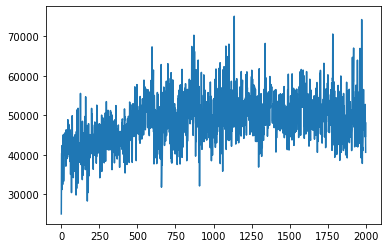

In [ ]:
plt.plot(TrainingPortfolio)

(array([  3.,  17.,  98., 405., 671., 539., 206.,  46.,  11.,   4.]),
 array([25076.3308    , 30074.95967   , 35073.58854   , 40072.21741   ,
        45070.84628   , 50069.47515   , 55068.10402   , 60066.73289   ,
        65065.36176   , 70063.99063   , 75062.61949999]),
 <BarContainer object of 10 artists>)

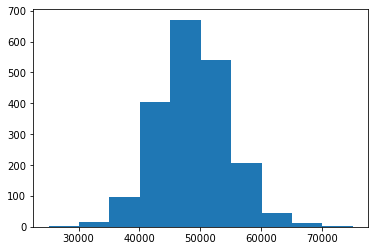

In [ ]:
plt.hist(TrainingPortfolio)

In [ ]:
np.mean(TestPortfolio)

29810.887477500015

(array([  1.,  15.,  94., 208., 449., 388., 726.,  86.,  28.,   5.]),
 array([17820.57 , 20033.566, 22246.562, 24459.558, 26672.554, 28885.55 ,
        31098.546, 33311.542, 35524.538, 37737.534, 39950.53 ]),
 <BarContainer object of 10 artists>)

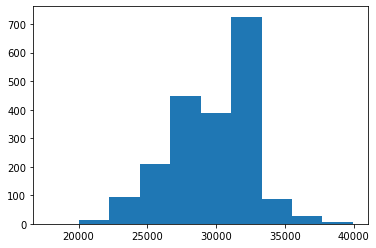

In [ ]:
plt.hist(TestPortfolio)

(array([ 24., 204., 539., 553., 388., 203.,  58.,  20.,   9.,   2.]),
 array([11664.905 , 15620.0205, 19575.136 , 23530.2515, 27485.367 ,
        31440.4825, 35395.598 , 39350.7135, 43305.829 , 47260.9445,
        51216.06  ]),
 <BarContainer object of 10 artists>)

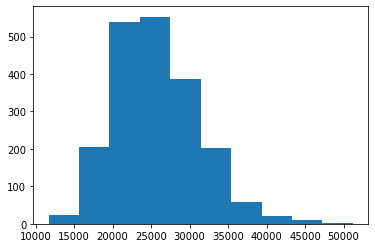

In [ ]:
plt.hist(RandomPortfolio)

In [ ]:
np.mean(RandomPortfolio)

25663.900752499667

In [ ]:
test_data[-1]

array([159.54, 102.63,  54.46])

In [ ]:
PercentIncrease=(test_data[-1]-test_data[0])/test_data[0]

In [ ]:
np.mean(PercentIncrease)

0.30142914393594666